In [1]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import preprocessing

import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
data = pd.read_csv('C:/Users/Adyasha/Downloads/assignment/loan.csv')
data.shape

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3326: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(39717, 111)

In [3]:
all_nan_columns = data.isna().all()
count_all_nan_columns = all_nan_columns.sum()

print(f"Number of columns with all values as NaN: {count_all_nan_columns}")

# #removing all the column having all the values as NAN
# data.dropna(axis=1, how='all', inplace=True)
# data.isna().sum()


nan_percentages = data.isnull().mean() * 100
columns_to_remove = nan_percentages[nan_percentages > 30].index
print(f"Number of columns with greater than 30% NaN values: {len(columns_to_remove)}")
data = data.drop(columns=columns_to_remove)

Number of columns with all values as NaN: 54
Number of columns with greater than 30% NaN values: 58


In [4]:
data.shape

(39717, 53)

In [5]:
data.drop(['pymnt_plan', "initial_list_status",'collections_12_mths_ex_med','policy_code',
           'acc_now_delinq', 'application_type', 'pub_rec_bankruptcies', 
           'tax_liens', 'delinq_amnt'], axis = 1, inplace = True)

In [6]:
# Removing below features as it doesnt contribute to the loan defaulting in any way due to irrelevant information

data.drop(["id", "member_id", "url", "title", "emp_title", "zip_code", "last_credit_pull_d", 
                "addr_state","out_prncp_inv","total_pymnt_inv","funded_amnt", "delinq_2yrs", 
                "revol_bal", "out_prncp", "total_pymnt", "total_rec_prncp", "total_rec_int", 
                "total_rec_late_fee", "recoveries", "collection_recovery_fee", "last_pymnt_d", 
                "last_pymnt_amnt", "chargeoff_within_12_mths"], axis = 1, inplace = True)

In [7]:
#removing columns with sames values in all the rows


row_wise_duplicates = data.T.duplicated(keep='first')
columns_to_remove = data.columns[row_wise_duplicates]
print(columns_to_remove)

data = data.drop(columns=columns_to_remove)

Index([], dtype='object')


In [8]:
#remove the columns having same column when compared with each other for all rows


column_wise_duplicates = data.T.duplicated(keep='first') | data.T.duplicated(keep='last')
columns_to_remove = data.columns[column_wise_duplicates]
print(columns_to_remove)

data = data.drop(columns=columns_to_remove)

Index([], dtype='object')


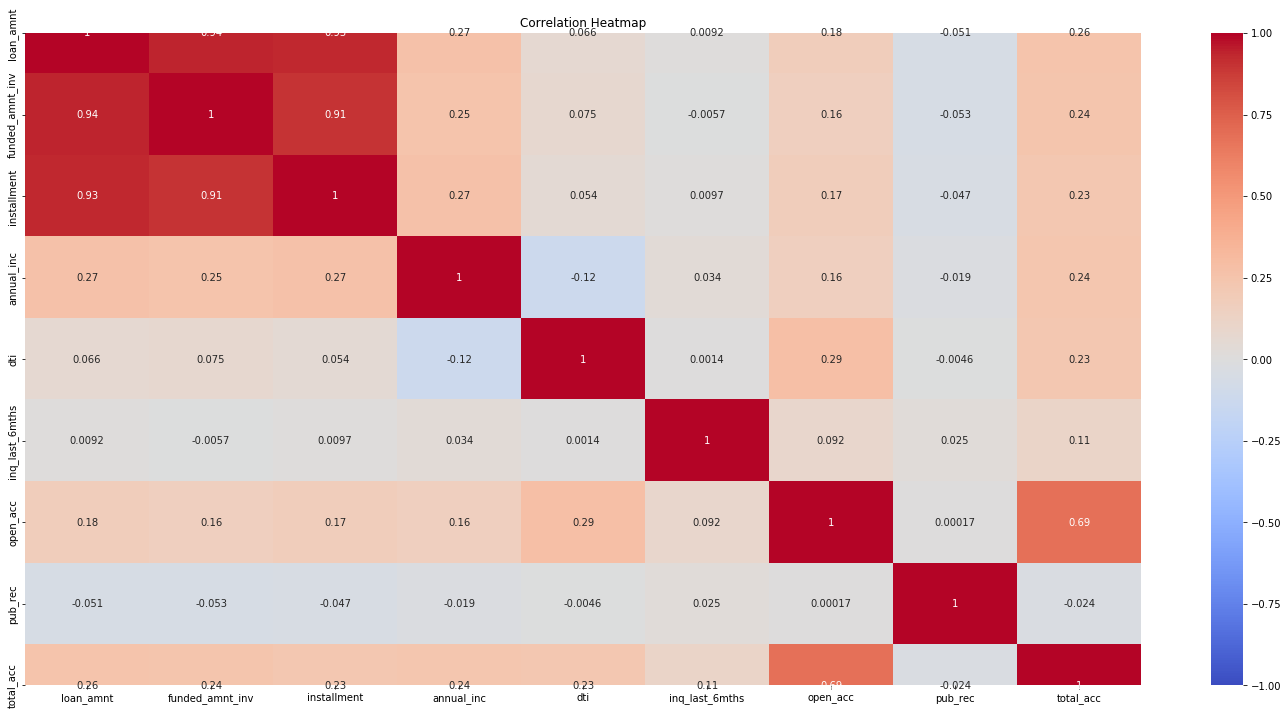

In [9]:
# Checking correlation and using heatmap

correlation_matrix = data.corr()

plt.figure(figsize=(25, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

In [10]:
# Multicolinearity between features

correlation_matrix = data.corr()

threshold = 0.8
highly_correlated_columns = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) >= threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated_columns.add(colname)

print(highly_correlated_columns)

data = data.drop(columns=highly_correlated_columns)

{'installment', 'funded_amnt_inv'}


In [11]:
data['emp_length'] = data['emp_length'].str.extract(r'(\d+)')
data.emp_length = data.emp_length.astype('float')

data['revol_util'] = data['revol_util'].str.replace(r'%', '', regex=True)
data['revol_util'] = pd.to_numeric(data['revol_util'])
data.revol_util = data.revol_util.astype('float')

data.term = data.term.apply(lambda x:x[:3])
data.term = data.term.astype('int')
data.int_rate = data.int_rate.apply(lambda x:x[:2])
data.int_rate = data.int_rate.astype('float')

In [12]:
for i in data.columns[data.dtypes == 'object']:
    print(data[i].value_counts())
    print('--------************************---------')

B    12020
A    10085
C     8098
D     5307
E     2842
F     1049
G      316
Name: grade, dtype: int64
--------************************---------
B3    2917
A4    2886
A5    2742
B5    2704
B4    2512
C1    2136
B2    2057
C2    2011
B1    1830
A3    1810
C3    1529
A2    1508
D2    1348
C4    1236
C5    1186
D3    1173
A1    1139
D4     981
D1     931
D5     874
E1     763
E2     656
E3     553
E4     454
E5     416
F1     329
F2     249
F3     185
F4     168
F5     118
G1     104
G2      78
G4      56
G3      48
G5      30
Name: sub_grade, dtype: int64
--------************************---------
RENT        18899
MORTGAGE    17659
OWN          3058
OTHER          98
NONE            3
Name: home_ownership, dtype: int64
--------************************---------
Not Verified       16921
Verified           12809
Source Verified     9987
Name: verification_status, dtype: int64
--------************************---------
Dec-11    2260
Nov-11    2223
Oct-11    2114
Sep-11    2063
Aug-11    1928

In [13]:
data.shape

(39717, 19)

In [14]:
data.columns

Index(['loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'dti', 'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 'total_acc'], dtype='object')

In [15]:
# As we need find the contributing factors, hence removing "Current"

data = data[data.loan_status != "Current"]
data.loan_status.unique()

array(['Fully Paid', 'Charged Off'], dtype=object)

In [16]:
#Percentage of Nan values in each group

(data.isna().sum()/len(data.index))*100

loan_amnt              0.000000
term                   0.000000
int_rate               0.000000
grade                  0.000000
sub_grade              0.000000
emp_length             2.677761
home_ownership         0.000000
annual_inc             0.000000
verification_status    0.000000
issue_d                0.000000
loan_status            0.000000
purpose                0.000000
dti                    0.000000
earliest_cr_line       0.000000
inq_last_6mths         0.000000
open_acc               0.000000
pub_rec                0.000000
revol_util             0.129611
total_acc              0.000000
dtype: float64

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loan_amnt            38577 non-null  int64  
 1   term                 38577 non-null  int32  
 2   int_rate             38577 non-null  float64
 3   grade                38577 non-null  object 
 4   sub_grade            38577 non-null  object 
 5   emp_length           37544 non-null  float64
 6   home_ownership       38577 non-null  object 
 7   annual_inc           38577 non-null  float64
 8   verification_status  38577 non-null  object 
 9   issue_d              38577 non-null  object 
 10  loan_status          38577 non-null  object 
 11  purpose              38577 non-null  object 
 12  dti                  38577 non-null  float64
 13  earliest_cr_line     38577 non-null  object 
 14  inq_last_6mths       38577 non-null  int64  
 15  open_acc             38577 non-null 

In [18]:
data = data.dropna()

C:\Users\Adyasha\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


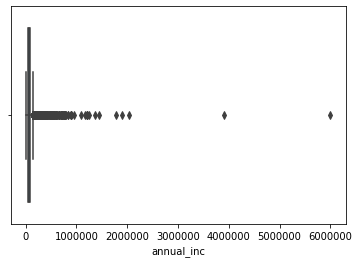

In [19]:
sns.boxplot(data['annual_inc'])

## Outlier
As we can see in the above plot, there are outlier present.

The values after 95 percentile seems to be disconected from the general distribution.Hence considering threshold for removing outliers as 0.95

In [20]:
quantile_info = data.annual_inc.quantile([0.5, 0.75,0.90, 0.95, 0.97,0.98, 0.99])
quantile_info

0.50     60000.00
0.75     83000.00
0.90    116714.40
0.95    142000.00
0.97    166307.32
0.98    189996.00
0.99    235000.00
Name: annual_inc, dtype: float64

In [21]:
annual_inc_95 = data['annual_inc'].quantile(0.95)
data = data[data.annual_inc <= annual_inc_95]

C:\Users\Adyasha\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


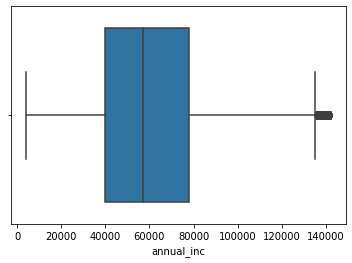

In [22]:
sns.boxplot(data.annual_inc)

C:\Users\Adyasha\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


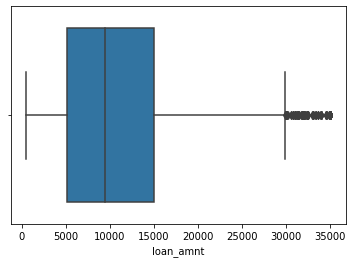

In [23]:
sns.boxplot(data.loan_amnt)

In [24]:
data.loan_amnt.quantile([0.75,0.90,0.95,0.97,0.975, 0.98, 0.99, 1.0])

0.750    15000.00
0.900    20000.00
0.950    25000.00
0.970    25878.25
0.975    28000.00
0.980    30000.00
0.990    35000.00
1.000    35000.00
Name: loan_amnt, dtype: float64

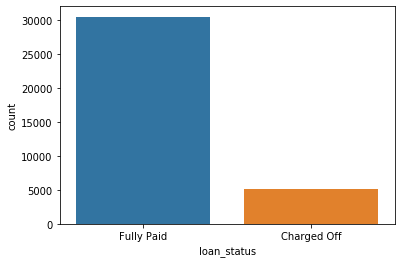

In [25]:
sns.countplot(x = 'loan_status', data = data)

In [26]:
data.sub_grade

0        B2
1        C4
2        C5
3        C1
5        A4
         ..
39711    B1
39712    A4
39713    C1
39714    A4
39716    E2
Name: sub_grade, Length: 35630, dtype: object

In [27]:
data.sub_grade = pd.to_numeric(data.sub_grade.apply(lambda x : x[-1]))
data.sub_grade.head()

0    2
1    4
2    5
3    1
5    4
Name: sub_grade, dtype: int64

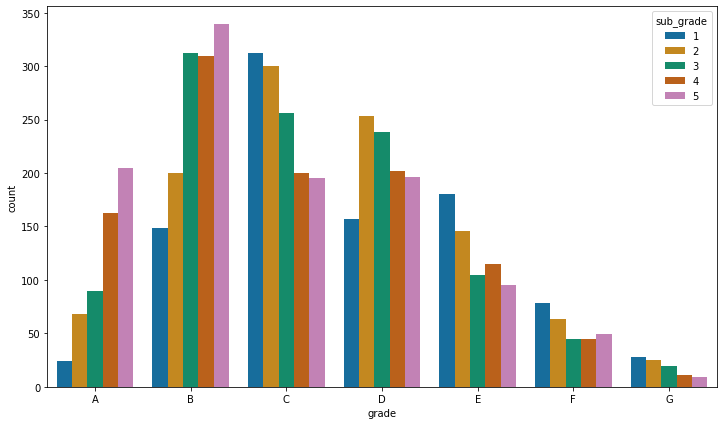

In [28]:
fig, ax = plt.subplots(figsize=(12,7))
sns.set_palette('colorblind')
sns.countplot(x = 'grade', order = ['A', 'B', 'C', 'D', 'E', 'F', 'G'] , hue = 'sub_grade',
              data = data[data.loan_status == 'Charged Off'])

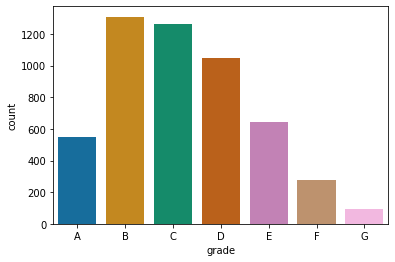

In [29]:
sns.countplot(x = 'grade', data = data[data.loan_status == 'Charged Off'], 
              order = ['A', 'B', 'C', 'D', 'E', 'F', 'G'])

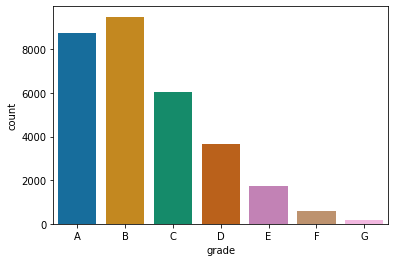

In [30]:
sns.countplot(x = 'grade', data = data[data.loan_status == 'Fully Paid'], 
              order = ['A', 'B', 'C', 'D', 'E', 'F', 'G'])

In [31]:
#replacing 'NONE' with 'OTHERS'
data['home_ownership'].replace(to_replace = ['NONE'],value='OTHER',inplace = True)

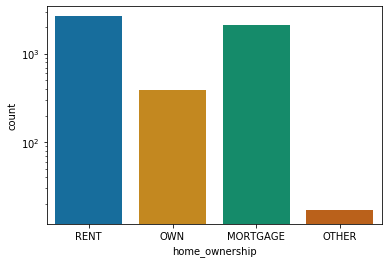

In [57]:
fig, ax = plt.subplots(figsize = (6,4))
ax.set(yscale = 'log')
sns.countplot(x='home_ownership', data=data[data['loan_status']=='Charged Off'])

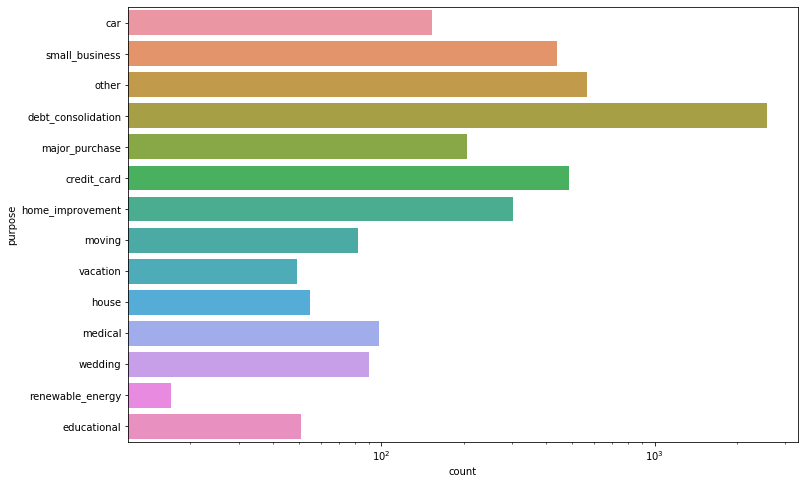

In [32]:
fig, ax = plt.subplots(figsize = (12,8))
ax.set(xscale = 'log')
sns.countplot(y ='purpose', data=data[data.loan_status == 'Charged Off'])

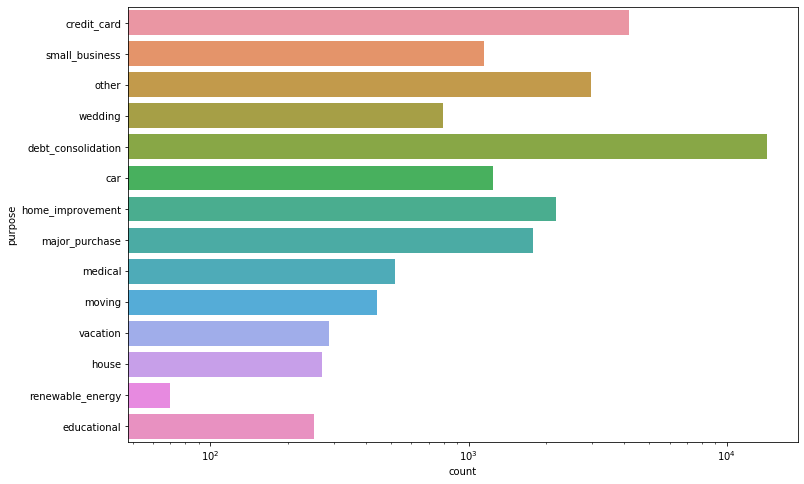

In [33]:
fig, ax = plt.subplots(figsize = (12,8))
ax.set(xscale = 'log')
sns.countplot(y ='purpose', data=data[data.loan_status == 'Fully Paid'])

In [34]:
#creating bins for int_rate,open_acc,revol_util,total_acc
data['int_rate_groups'] = pd.cut(data['int_rate'], bins=7,precision =0,
                                 labels=['5%-9%','9%-13%','13%-17%','17%-21%','21%-24%','24%-27%', '27%-30%'])
data['annual_inc_groups'] = pd.cut(data['annual_inc'], bins=5,precision =0,
                                   labels =['3k-31k','31k-58k','58k-85k','85k-112k','112k-140k'])

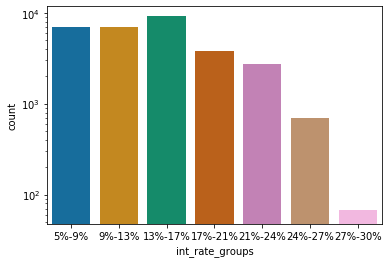

In [35]:
fig, ax = plt.subplots(figsize = (6,4))
ax.set(yscale = 'log')
sns.countplot(x='int_rate_groups', data = data[data['loan_status']=='Fully Paid'])

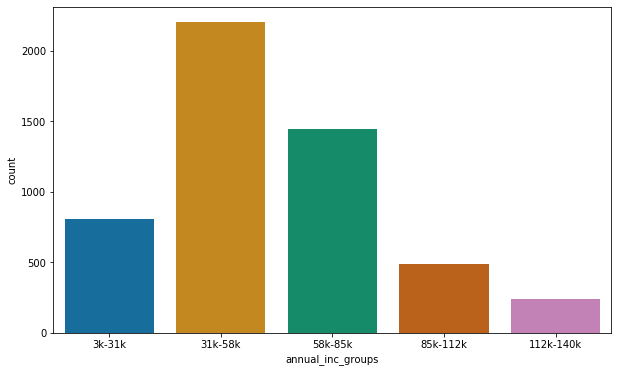

In [36]:
fig, ax = plt.subplots(figsize = (10,6))
sns.countplot(x='annual_inc_groups', data=data[data.loan_status == 'Charged Off'])

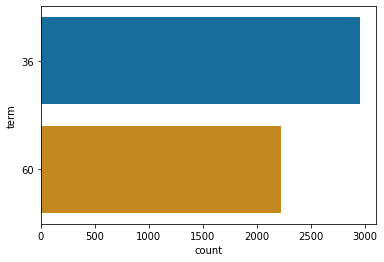

In [37]:
sns.countplot(y='term', data=data[data['loan_status']=='Charged Off'])

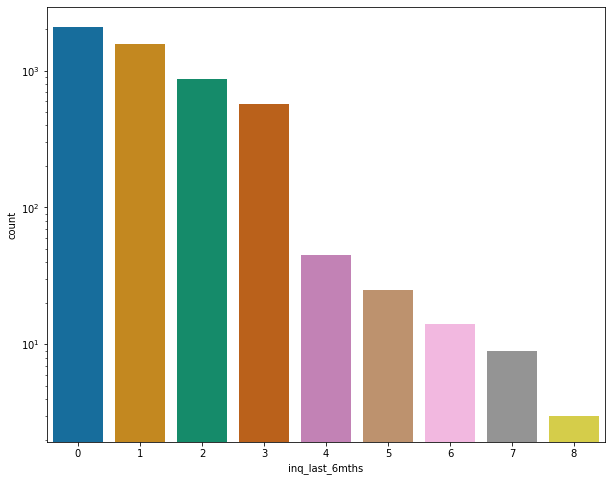

In [38]:
fig,ax = plt.subplots(figsize = (10,8))
ax.set_yscale('log')
sns.countplot(x='inq_last_6mths', data=data[data['loan_status']=='Charged Off'])

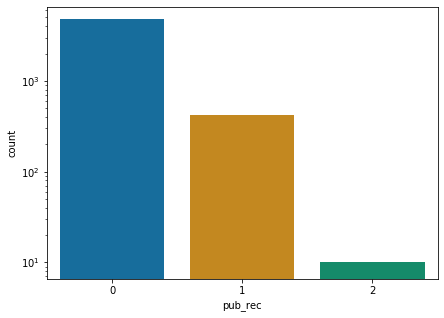

In [39]:
fig,ax = plt.subplots(figsize = (7,5))
ax.set_yscale('log')
sns.countplot(x='pub_rec', data=data[data['loan_status']=='Charged Off'])

In [40]:
## Extracting month and year
df_month_year = data['issue_d'].str.partition("-", True)     
data['issue_month']=df_month_year[0]                       
data['issue_year']='20' + df_month_year[2]

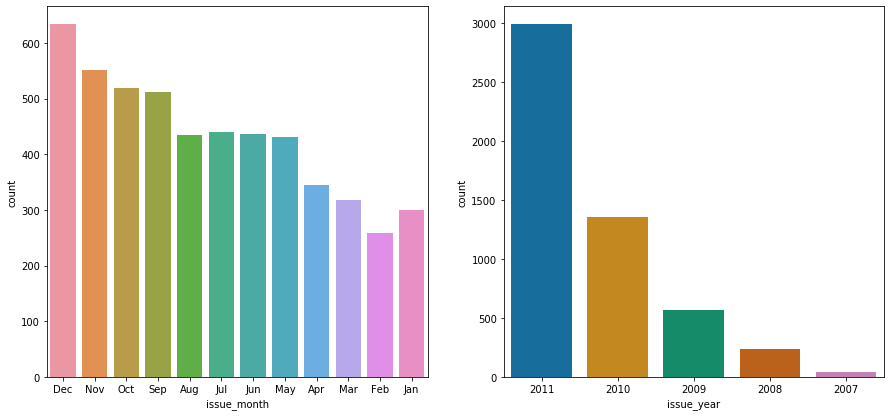

In [41]:
plt.figure(figsize=(15,15))
plt.subplot(221)
sns.countplot(x='issue_month', data=data[data['loan_status']=='Charged Off'])
plt.subplot(222)
sns.countplot(x='issue_year', data=data[data['loan_status']=='Charged Off'])

In [42]:
data['loan_amnt_groups'] = pd.cut(data['loan_amnt'], bins=7,precision =0,
                                  labels=['0-5k','5k-10k','10k-15k','15k-20k','20k-25k','25k-30k','30k-35k'])

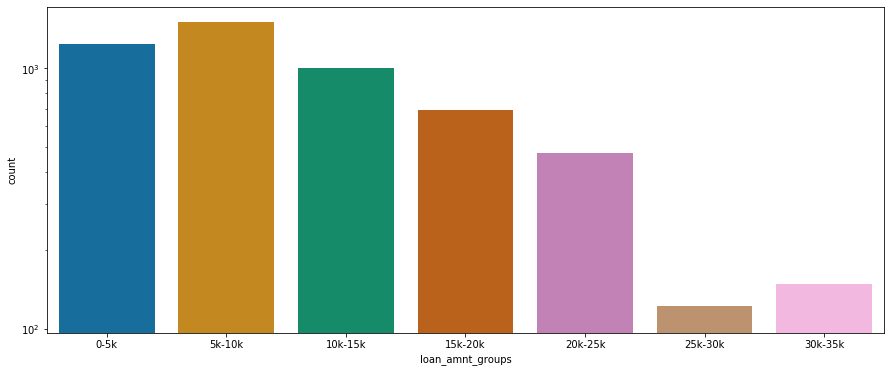

In [43]:
fig,ax = plt.subplots(figsize = (15,6))
ax.set_yscale('log')
sns.countplot(x='loan_amnt_groups', data=data[data['loan_status']=='Charged Off'])

# We can tell this from above Analysis 

### There is a more probability of defaulting when : 

- Applicants having house_ownership as 'RENT'
- Applicants who receive interest at the rate of 13-17%
- Applicants who have an income of range 31k - 58k
- Applicants with employement length of 10
- Loan amount is between 5k - 10k
- Term of 36 months
- When the loan status is Not verified
- When the no of enquiries in last 6 months is 0
- When the purpose is 'debt_consolidation'

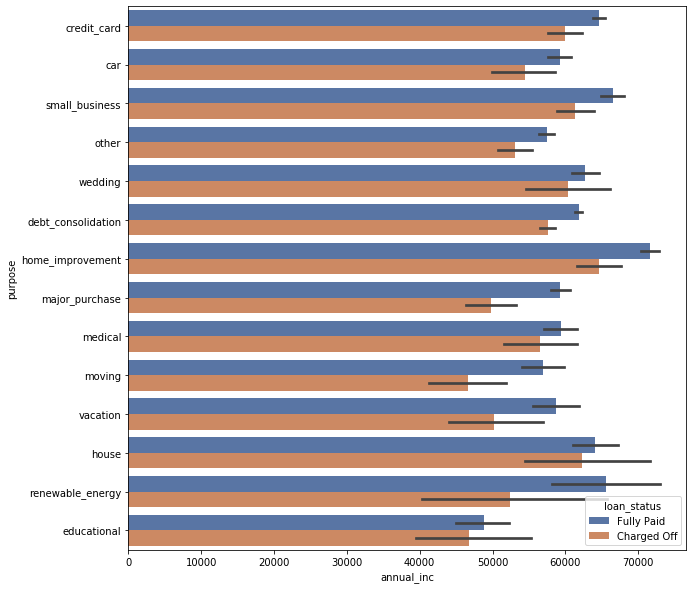

In [44]:
plt.figure(figsize=(10,10))
sns.barplot(data =data,x='annual_inc', y='purpose', hue ='loan_status',palette="deep")
plt.show()

- Applicants with higher salary mostly applied loans for "home_improvment", "house", "renewable_energy" and "small_businesses"

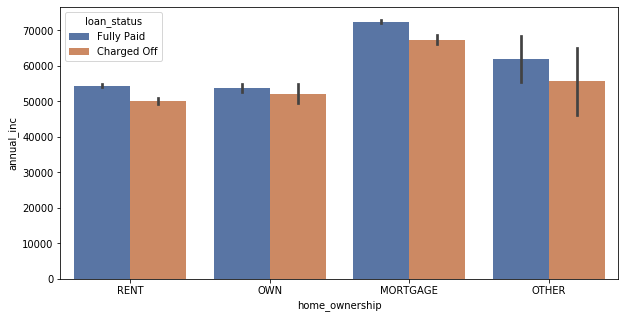

In [58]:
plt.figure(figsize=(10,5))
sns.barplot(data =data,x='home_ownership', y='annual_inc', hue ='loan_status',palette="deep")
plt.show()

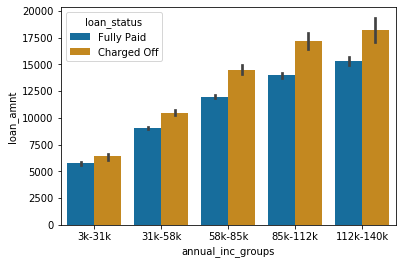

In [46]:
sns.barplot(x = "annual_inc_groups", y = "loan_amnt", hue = 'loan_status', data = data)

Across all the income groups, the loan_amount is higher for applicants who defaulted.

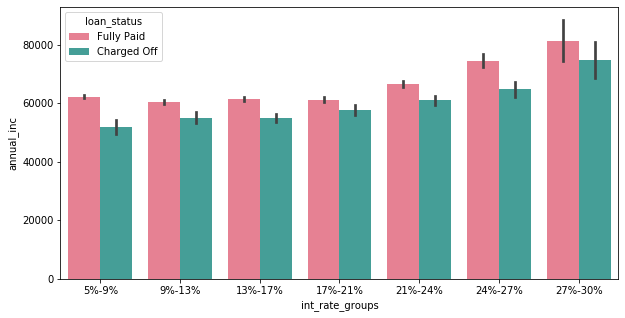

In [59]:
plt.figure(figsize=(10,5))
sns.barplot(data =data,x='int_rate_groups', y='annual_inc', hue ='loan_status',palette="husl")
plt.show()

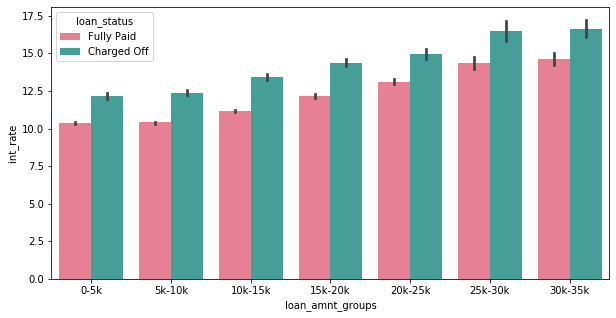

In [60]:
plt.figure(figsize=(10,5))
sns.barplot(data =data,x='loan_amnt_groups', y='int_rate', hue ='loan_status',palette="husl")
plt.show()

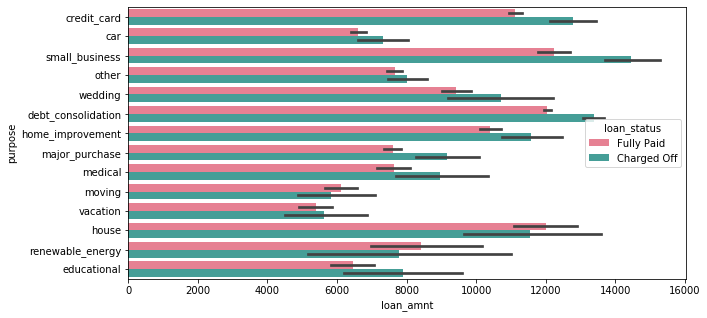

In [61]:
plt.figure(figsize=(10,5))
sns.barplot(data =data,x='loan_amnt', y='purpose', hue ='loan_status',palette="husl")
plt.show()

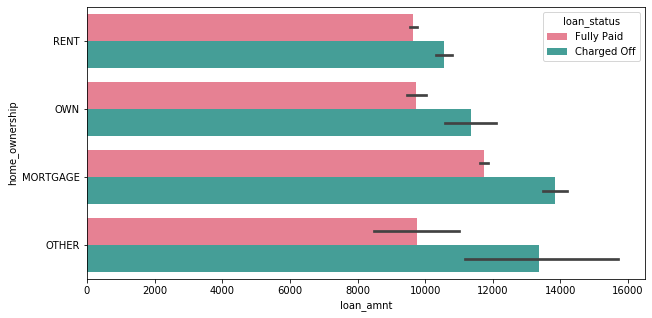

In [62]:
plt.figure(figsize=(10,5))
sns.barplot(data =data,x='loan_amnt', y='home_ownership', hue ='loan_status',palette="husl")
plt.show()

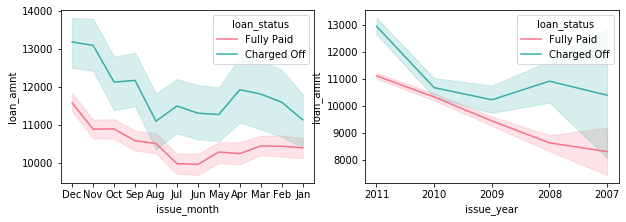

In [63]:
plt.figure(figsize=(10,7))
plt.subplot(221)
sns.lineplot(data =data,y='loan_amnt', x='issue_month', hue ='loan_status',palette="husl")
plt.subplot(222)
sns.lineplot(data =data,y='loan_amnt', x='issue_year', hue ='loan_status',palette="husl")

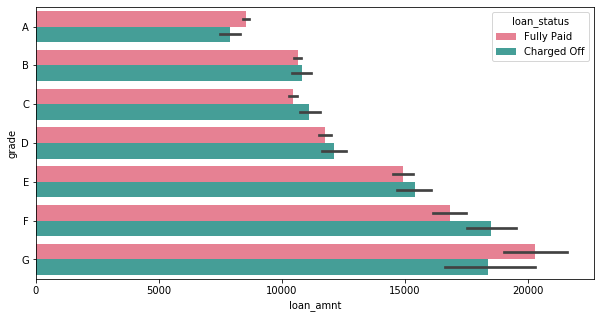

In [64]:
plt.figure(figsize=(10,5))
sns.barplot(data =data,x='loan_amnt', y='grade', hue ='loan_status',palette="husl", order=['A','B','C','D','E','F','G'])
plt.show()

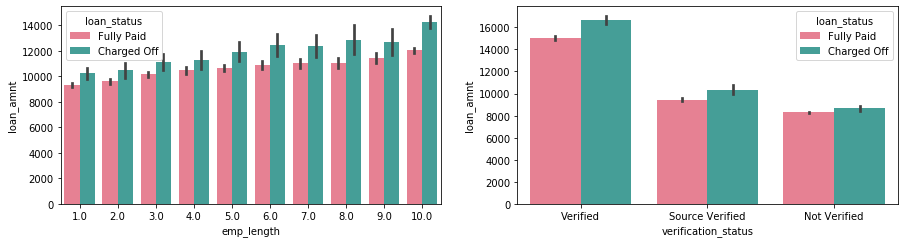

In [68]:
plt.figure(figsize=(15,8))
plt.subplot(221)
sns.barplot(data =data,y='loan_amnt', x='emp_length', hue ='loan_status',palette="husl")
plt.subplot(222)
sns.barplot(data =data,y='loan_amnt', x='verification_status', hue ='loan_status',palette="husl")


- Employees with longer working history got the loan approved for a higher amount.
- verified loan applications tend to have higher loan amount, which might indicate that the firms are first verifying the loans with higher values.

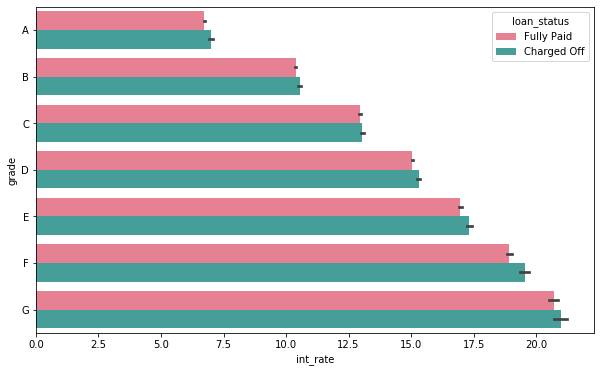

In [69]:
plt.figure(figsize=(10,6))
sns.barplot(data =data,x='int_rate', y='grade', hue ='loan_status',palette="husl", order=['A','B','C','D','E','F','G'])
plt.show()

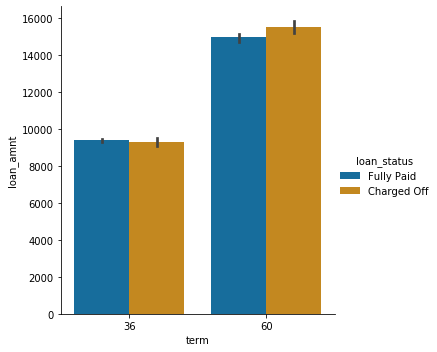

In [55]:
sns.catplot(x = 'term', y = 'loan_amnt', data = data,hue = 'loan_status', kind = 'bar')

# From the above analysis with respect to the charged off loans. There is a more probability of defaulting when : 

- Applicants taking loan for 'home improvement' and have income of 60k -70k
- Applicants whose home ownership is 'MORTGAGE and have income of 60-70k
- Applicants who receive interest at the rate of 21-24% and have an income of 70k-80k
- Applicants who have taken a loan in the range 30k - 35k and are charged interest rate of 15-17.5 %
- Applicants who have taken a loan for small business and the loan amount is greater than 14k
- Applicants whose home ownership is 'MORTGAGE and have loan of 14-16k
- When grade is F and loan amount is between 15k-20k
- When employment length is 10yrs and loan amount is 12k-14k 
- When the loan is verified and loan amount is above 16k